<a href="https://colab.research.google.com/github/SteevyG1350/backtest/blob/main/backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Install necessary libraries
!pip install pandas --upgrade pandas-ta matplotlib

import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload your tick data file (e.g., 'tick_data.csv')
print("Please upload your tick data file:")
uploaded = files.upload()

# Get the filename of the uploaded file
if uploaded:
    filename = next(iter(uploaded))
    print(f"\nUploaded file: {filename}")

Please upload your tick data file:


Saving XAUUSD1.csv to XAUUSD1.csv

Uploaded file: XAUUSD1.csv


In [53]:
# Load the data
# IMPORTANT: Adjust the column names and separator based on your file format.
# This assumes your data is in OHLCV format (Open, High, Low, Close, Volume)
# with separate date and time columns, similar to the XAUUSD files.
try:
    df = pd.read_csv(
        filename,
        header=None,
        sep=r'\s+', # Adjust separator here (e.g., ',' for comma-separated)
        names=['date', 'time', 'open', 'high', 'low', 'close', 'volume']
    )
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.set_index('datetime', inplace=True)
    df.drop(['date', 'time'], axis=1, inplace=True)
    df.dropna(inplace=True) # Remove rows with any NaN values

    print("Data successfully loaded. Here are the first 5 rows:")
    print(df.head())

except Exception as e:
    print(f"An error occurred during data loading: {e}")

Data successfully loaded. Here are the first 5 rows:
                         open      high       low     close  volume
datetime                                                           
2025-04-30 22:08:00  3284.555  3284.805  3284.455  3284.615       1
2025-04-30 22:09:00  3284.645  3284.725  3284.215  3284.365       1
2025-04-30 22:10:00  3284.515  3284.625  3280.795  3280.795       1
2025-04-30 22:11:00  3280.805  3283.515  3280.275  3280.315       1
2025-04-30 22:12:00  3280.345  3282.285  3280.245  3282.265       1


In [78]:
def define_strategy(df):
    # Calculate technical indicators
    df.ta.atr(length=14, append=True, col_names='ATR_14')
    df.ta.rsi(length=14, append=True, col_names='RSI_14')
    df.ta.sma(length=20, append=True, col_names='SMA_20')
    df.ta.sma(length=50, append=True, col_names='SMA_50')

    # Regime Detection
    ohlc_dict = {'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'}
    df_60m = df.resample('60min').apply(ohlc_dict).dropna()
    df_60m['sma50'] = ta.sma(df_60m['close'], length=50)
    df_60m['sma50_prev'] = df_60m['sma50'].shift(1)
    bbands = ta.bbands(df_60m['close'], length=20, std=2)
    df_60m['bb_width'] = bbands['BBB_20_2.0']
    df_60m['bb_width_sma50'] = ta.sma(df_60m['bb_width'], length=50)
    def get_regime(row):
        if row['sma50'] > row['sma50_prev']: return "TREND_UP"
        elif row['sma50'] < row['sma50_prev']: return "TREND_DOWN"
        else: return "RANGE_HIGH_VOL" if row['bb_width'] > row['bb_width_sma50'] else "RANGE_LOW_VOL"
    df_60m['regime'] = df_60m.apply(get_regime, axis=1)
    df['regime'] = df_60m['regime'].reindex(df.index, method='ffill')

    # Signal Generation
    # Removed candlestick pattern calculation and usage
    ma_slope_up = df['SMA_20'] > df['SMA_50']
    ma_slope_down = df['SMA_20'] < df['SMA_50']

    # Simplified signals based on MA slope and regime (adjust as needed)
    df['long_signal'] = (df['regime'] != "TREND_DOWN") & ma_slope_up
    df['short_signal'] = (df['regime'] != "TREND_UP") & ma_slope_down


    return df

# --- Backtesting Engine ---
def run_backtest(df, initial_capital, risk_pct, atr_mult_sl, atr_mult_trail, rr_target, unit_value,
   partial_exit, partial_exit_pct):
    trades = []
    equity = initial_capital
    equity_curve = [initial_capital]
    position = None
    highest_since_entry = 0
    lowest_since_entry = 0
    previous_equity = initial_capital # Keep track of equity before the current trade

    for i in range(1, len(df)):
        row = df.iloc[i]

        if position is None:
            previous_equity = equity # Update previous equity before a new trade
            if row['long_signal']:
                sl_dist = row['ATR_14'] * atr_mult_sl
                if sl_dist == 0: continue
                tp_dist = sl_dist * rr_target
                stop_loss = row['close'] - sl_dist
                take_profit = row['close'] + tp_dist

                max_risk_amount = equity * risk_pct
                qty = np.floor(max_risk_amount / (sl_dist * unit_value))

                if qty > 0:
                    position = {'type': 'long', 'entry_price': row['close'], 'stop_loss': stop_loss,
   'take_profit': take_profit, 'quantity': qty, 'entry_time': row.name}
                    highest_since_entry = row['high']

            elif row['short_signal']:
                sl_dist = row['ATR_14'] * atr_mult_sl
                if sl_dist == 0: continue
                tp_dist = sl_dist * rr_target
                stop_loss = row['close'] + sl_dist
                take_profit = row['close'] - tp_dist

                max_risk_amount = equity * risk_pct
                qty = np.floor(max_risk_amount / (sl_dist * unit_value))

                if qty > 0:
                    position = {'type': 'short', 'entry_price': row['close'], 'stop_loss': stop_loss,
   'take_profit': take_profit, 'quantity': qty, 'entry_time': row.name}
                    lowest_since_entry = row['low']

        elif position is not None:
            if position['type'] == 'long':
                if partial_exit and not position.get('partial_exited', False):
                    partial_tp_price = position['entry_price'] + (position['take_profit'] - position[
   'entry_price']) * 0.5
                    if row['high'] >= partial_tp_price:
                        partial_qty = position['quantity'] * partial_exit_pct
                        pnl = (partial_tp_price - position['entry_price']) * partial_qty * unit_value
                        equity += pnl
                        drawdown_pct = (previous_equity - equity) / previous_equity * 100 if previous_equity > 0 else 0
                        trades.append({'entry_time': position['entry_time'], 'exit_time': row.name, 'pnl':
   pnl, 'type': 'long_partial', 'drawdown_pct': drawdown_pct})
                        position['quantity'] -= partial_qty
                        position['partial_exited'] = True

                highest_since_entry = max(highest_since_entry, row['high'])
                trail_stop_price = highest_since_entry - row['ATR_14'] * atr_mult_trail
                position['stop_loss'] = max(position['stop_loss'], trail_stop_price)

                if row['low'] <= position['stop_loss']:
                    pnl = (position['stop_loss'] - position['entry_price']) * position['quantity'] * \
   unit_value
                    equity += pnl
                    drawdown_pct = (previous_equity - equity) / previous_equity * 100 if previous_equity > 0 else 0
                    trades.append({'entry_time': position['entry_time'], 'exit_time': row.name, 'pnl': pnl,
   'type': 'long', 'drawdown_pct': drawdown_pct})
                    position = None
                elif row['high'] >= position['take_profit']:
                    pnl = (position['take_profit'] - position['entry_price']) * position['quantity'] * \
   unit_value
                    equity += pnl
                    drawdown_pct = (previous_equity - equity) / previous_equity * 100 if previous_equity > 0 else 0
                    trades.append({'entry_time': position['entry_time'], 'exit_time': row.name, 'pnl': pnl,
   'type': 'long', 'drawdown_pct': drawdown_pct})
                    position = None

            elif position['type'] == 'short':
                if partial_exit and not position.get('partial_exited', False):
                    partial_tp_price = position['entry_price'] - (position['entry_price'] - position[
   'take_profit']) * 0.5
                    if row['low'] <= partial_tp_price:
                        partial_qty = position['quantity'] * partial_exit_pct
                        pnl = (position['entry_price'] - partial_tp_price) * partial_qty * unit_value
                        equity += pnl
                        drawdown_pct = (previous_equity - equity) / previous_equity * 100 if previous_equity > 0 else 0
                        trades.append({'entry_time': position['entry_time'], 'exit_time': row.name, 'pnl':
   pnl, 'type': 'short_partial', 'drawdown_pct': drawdown_pct})
                        position['quantity'] -= partial_qty
                        position['partial_exited'] = True

                lowest_since_entry = min(lowest_since_entry, row['low'])
                trail_stop_price = lowest_since_entry + row['ATR_14'] * atr_mult_trail
                position['stop_loss'] = min(position['stop_loss'], trail_stop_price)

                if row['high'] >= position['stop_loss']:
                    pnl = (position['entry_price'] - position['stop_loss']) * position['quantity'] * \
   unit_value
                    equity += pnl
                    drawdown_pct = (previous_equity - equity) / previous_equity * 100 if previous_equity > 0 else 0
                    trades.append({'entry_time': position['entry_time'], 'exit_time': row.name, 'pnl': pnl,
   'type': 'short', 'drawdown_pct': drawdown_pct})
                    position = None
                elif row['low'] <= position['take_profit']:
                    pnl = (position['entry_price'] - position['take_profit']) * position['quantity'] * \
   unit_value
                    equity += pnl
                    drawdown_pct = (previous_equity - equity) / previous_equity * 100 if previous_equity > 0 else 0
                    trades.append({'entry_time': position['entry_time'], 'exit_time': row.name, 'pnl': pnl,
   'type': 'short', 'drawdown_pct': drawdown_pct})
                    position = None

        equity_curve.append(equity)

    return equity, trades, equity_curve


--- Backtest Results ---
Final Equity: 283319.55
Total Trades: 6961
Wins: 3113
Losses: 3848
Win Rate: 44.72%
Average PnL per trade: 25.04
Average Win PnL: 475.41
Average Loss PnL: -339.30
Maximum Drawdown: 16762.10
Maximum Drawdown %: 5.79%
Sharpe Ratio (Annualized): 0.25
Average Risk to Reward Ratio: 1.40

--- All Trades ---


,entry_time,exit_time,pnl,type,drawdown_pct
0,2025-04-30 22:57:00,2025-04-30 23:01:00,-216.162493,short,0.198314
1,2025-04-30 23:02:00,2025-04-30 23:11:00,216.721383,long_partial,-0.199222
2,2025-04-30 23:02:00,2025-04-30 23:11:00,433.442766,long,-0.597666
3,2025-04-30 23:12:00,2025-04-30 23:16:00,-217.114457,long,0.198398
4,2025-04-30 23:17:00,2025-04-30 23:18:00,-217.398534,long,0.199052
...,...,...,...,...,...
6956,2025-08-11 16:36:00,2025-08-11 16:40:00,564.029338,short_partial,-0.199298
6957,2025-08-11 16:36:00,2025-08-11 17:28:00,16.183875,short,-0.205016
6958,2025-08-11 17:29:00,2025-08-11 17:31:00,-566.772946,short,0.199857
6959,2025-08-11 17:32:00,2025-08-11 17:34:00,564.204489,short_partial,-0.199350


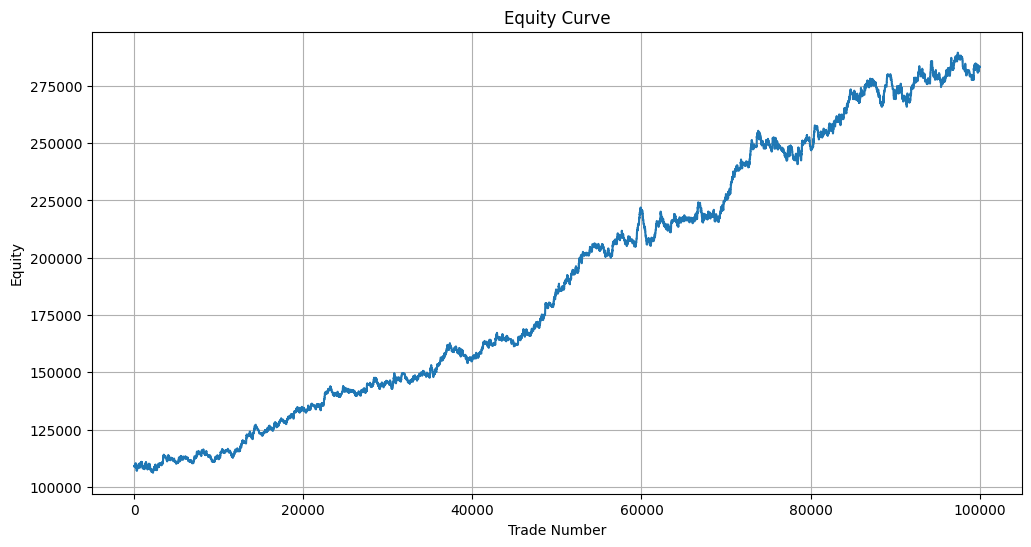

In [92]:
# --- Parameters ---
initial_capital = 109000
risk_pct = 0.002
atr_mult_sl = 1.094
atr_mult_trail = 4.093
rr_target = 3.990
unit_value = 1.0
partial_exit = True
partial_exit_pct = 0.5


# Define and run the backtest
df_strategy = define_strategy(df.copy())
final_equity, trades, equity_curve = run_backtest(df_strategy, initial_capital, risk_pct, atr_mult_sl,
   atr_mult_trail, rr_target, unit_value, partial_exit, partial_exit_pct)

# --- Results ---
if trades:
    trades_df = pd.DataFrame(trades)
    print("\n--- Backtest Results ---")
    print(f"Final Equity: {final_equity:.2f}")
    print(f"Total Trades: {len(trades_df)}")
    print(f"Wins: {len(trades_df[trades_df['pnl'] > 0])}")
    print(f"Losses: {len(trades_df[trades_df['pnl'] <= 0])}")
    if len(trades_df) > 0:
        print(f"Win Rate: {len(trades_df[trades_df['pnl'] > 0]) / len(trades_df) * 100:.2f}%")
        print(f"Average PnL per trade: {trades_df['pnl'].mean():.2f}")
        print(f"Average Win PnL: {trades_df[trades_df['pnl'] > 0]['pnl'].mean():.2f}" if len(trades_df[trades_df['pnl'] > 0]) > 0 else "Average Win PnL: N/A")
        print(f"Average Loss PnL: {trades_df[trades_df['pnl'] <= 0]['pnl'].mean():.2f}" if len(trades_df[trades_df['pnl'] <= 0]) > 0 else "Average Loss PnL: N/A")

        # Calculate Maximum Drawdown
        equity_curve_series = pd.Series(equity_curve)
        rolling_max = equity_curve_series.cummax()
        drawdown = rolling_max - equity_curve_series
        max_drawdown = drawdown.max()
        max_drawdown_pct = (max_drawdown / rolling_max.max()) * 100 if rolling_max.max() > 0 else 0


        print(f"Maximum Drawdown: {max_drawdown:.2f}")
        print(f"Maximum Drawdown %: {max_drawdown_pct:.2f}%")

        # Calculate Sharpe Ratio (assuming risk-free rate of 0 and annualization factor)
        # Need returns from equity curve for Sharpe Ratio
        returns = pd.Series(equity_curve).pct_change().dropna()
        if len(returns) > 0:
            # Assuming daily data for annualization factor, adjust if different
            annualization_factor = 252 # For daily data
            sharpe_ratio = (returns.mean() * annualization_factor) / (returns.std() * np.sqrt(annualization_factor))
            print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
        else:
            print("Sharpe Ratio: N/A (Not enough data for calculation)")


        # Calculate Risk to Reward Ratio (Average Win / Average Loss Magnitude)
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean()
        avg_loss = trades_df[trades_df['pnl'] <= 0]['pnl'].mean()
        if not np.isnan(avg_win) and not np.isnan(avg_loss) and avg_loss != 0:
            risk_to_reward_ratio = abs(avg_win / avg_loss)
            print(f"Average Risk to Reward Ratio: {risk_to_reward_ratio:.2f}")
        else:
             print("Average Risk to Reward Ratio: N/A")


    print("\n--- All Trades ---")
    display(trades_df) # Display the full trades DataFrame

    # Plot equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve)
    plt.title('Equity Curve')
    plt.xlabel('Trade Number')
    plt.ylabel('Equity')
    plt.grid(True)
    plt.show()

else:
    print("\nNo trades were executed.")

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
trades_df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
trades_df['pnl'].plot(kind='hist', bins=20, title='pnl')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [30]:
# Install TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz -O ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install ta-lib

--2025-08-12 07:56:40--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.13.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-08-12 07:56:40--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2025-08-12 07:56:40--  http://versaweb.dl.sour

In [47]:
import optuna
import pandas as pd
import numpy as np

# Ensure df is available from your data loading cell (Cell 2)
# If you restart your Colab runtime, you might need to re-run Cell 2 first.

def objective(trial):
    # Define the search space for the parameters
    # Optuna will suggest values within these ranges for each trial
    atr_mult_sl = trial.suggest_float("atr_mult_sl", 0.5, 2.5, step=0.1)
    atr_mult_trail = trial.suggest_float("atr_mult_trail", 2.0, 6.0, step=0.1)
    rr_target = trial.suggest_float("rr_target", 1.0, 5.0, step=0.1)
    risk_pct = trial.suggest_float("risk_pct", 0.005, 0.02, log=True) # Use log scale for percentage

    # Suggest a boolean for partial_exit
    partial_exit = trial.suggest_categorical("partial_exit", [True, False])

    # Only suggest partial_exit_pct if partial_exit is True
    partial_exit_pct = trial.suggest_float("partial_exit_pct", 0.1, 0.9, step=0.1) if partial_exit else 0.0

    # Run the backtest with the suggested parameters
    # It's crucial to pass a copy of df to define_strategy to avoid modifying the original
    df_strategy_trial = define_strategy(df.copy())

    final_equity, trades, equity_curve = run_backtest(
        df_strategy_trial,
        initial_capital=10000, # Keep initial capital fixed for optimization
        risk_pct=risk_pct,
        atr_mult_sl=atr_mult_sl,
        atr_mult_trail=atr_mult_trail,
        rr_target=rr_target,
        unit_value=1.0, # Keep fixed
        partial_exit=partial_exit,
        partial_exit_pct=partial_exit_pct
    )

    # --- Calculate Sharpe Ratio ---
    # Handle cases where no trades occur or equity_curve is too short
    if len(equity_curve) < 2:
        return 0.0 # Return a neutral or bad value if no meaningful data

    returns = pd.Series(equity_curve).pct_change().dropna()

    if returns.empty:
        return 0.0 # No returns to calculate Sharpe Ratio

    # Annualized Sharpe Ratio (assuming daily data, adjust annualization_factor if different)
    # For simplicity, assuming risk-free rate is 0
    daily_risk_free_rate = 0.0
    annualization_factor = np.sqrt(252) # 252 trading days in a year

    excess_returns = returns - daily_risk_free_rate / annualization_factor

    # Handle case where standard deviation is zero (e.g., all returns are the same)
    if np.std(excess_returns) == 0:
        return 0.0

    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * annualization_factor

    # Optuna aims to maximize the objective function, so we return the Sharpe Ratio
    return sharpe_ratio

# Create a study and optimize
# 'maximize' because we want to find the highest Sharpe Ratio
study = optuna.create_study(direction="maximize")

# Run the optimization for a number of trials
# You can increase n_trials for a more thorough search, but it will take longer
print("Starting optimization...")
study.optimize(objective, n_trials=100) # Adjust n_trials as needed

# Print the best parameters found
print("\nOptimization finished.")
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value:.4f} (Best Sharpe Ratio found)")
print("  Best Parameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-12 08:15:56,970] A new study created in memory with name: no-name-d3f9830f-c029-4969-bad4-5e713c5f9c47


Starting optimization...


[I 2025-08-12 08:16:04,884] Trial 0 finished with value: 0.2402715338782695 and parameters: {'atr_mult_sl': 0.7, 'atr_mult_trail': 4.300000000000001, 'rr_target': 3.4000000000000004, 'risk_pct': 0.016631814524511415, 'partial_exit': True, 'partial_exit_pct': 0.5}. Best is trial 0 with value: 0.2402715338782695.
[I 2025-08-12 08:16:11,465] Trial 1 finished with value: 0.0934775147284975 and parameters: {'atr_mult_sl': 2.5, 'atr_mult_trail': 2.7, 'rr_target': 3.3000000000000003, 'risk_pct': 0.007397140206802841, 'partial_exit': False}. Best is trial 0 with value: 0.2402715338782695.
[I 2025-08-12 08:16:19,300] Trial 2 finished with value: 0.34059740589297577 and parameters: {'atr_mult_sl': 0.6, 'atr_mult_trail': 3.8, 'rr_target': 3.3000000000000003, 'risk_pct': 0.009239670584243471, 'partial_exit': True, 'partial_exit_pct': 0.8}. Best is trial 2 with value: 0.34059740589297577.
[I 2025-08-12 08:16:25,953] Trial 3 finished with value: 0.22273242904612056 and parameters: {'atr_mult_sl': 1.


Optimization finished.
Best trial:
  Value: 0.7618 (Best Sharpe Ratio found)
  Best Parameters: 
    atr_mult_sl: 0.5
    atr_mult_trail: 2.1
    rr_target: 1.5
    risk_pct: 0.010072079759217673
    partial_exit: True
    partial_exit_pct: 0.9


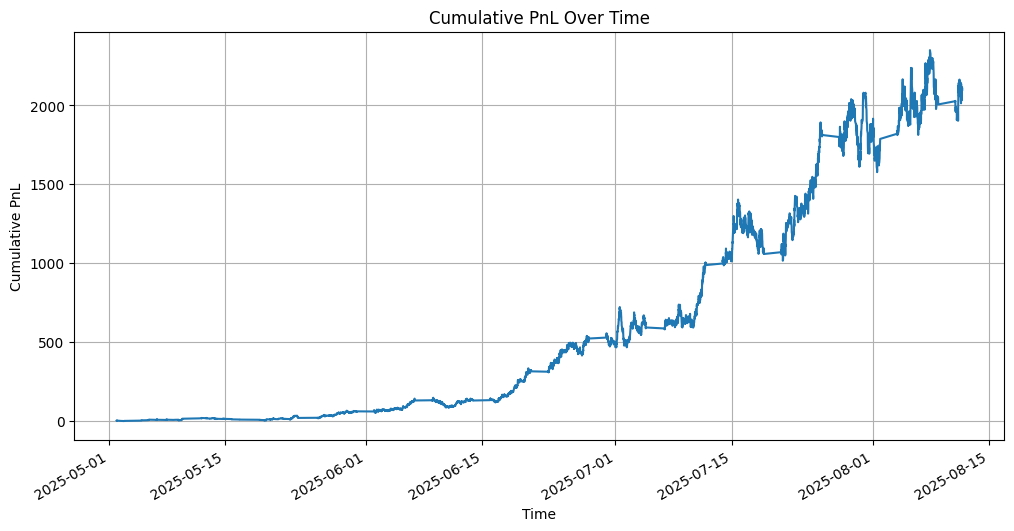

In [84]:
# Plot PnL over time
trades_df.set_index('exit_time')['pnl'].cumsum().plot(figsize=(12, 6), title='Cumulative PnL Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

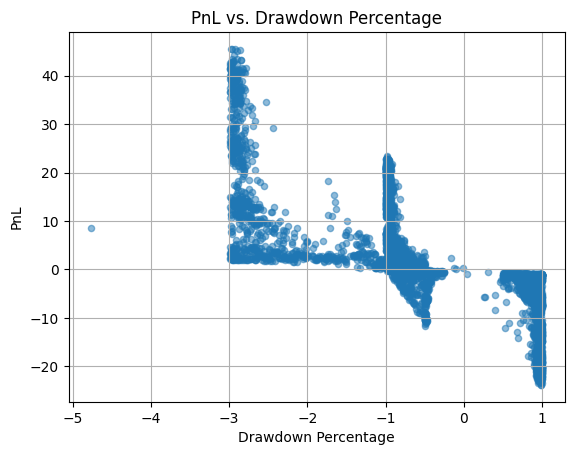

In [85]:
# Scatter plot of PnL vs. Drawdown Percentage
trades_df.plot(kind='scatter', x='drawdown_pct', y='pnl', alpha=0.5, title='PnL vs. Drawdown Percentage')
plt.xlabel('Drawdown Percentage')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

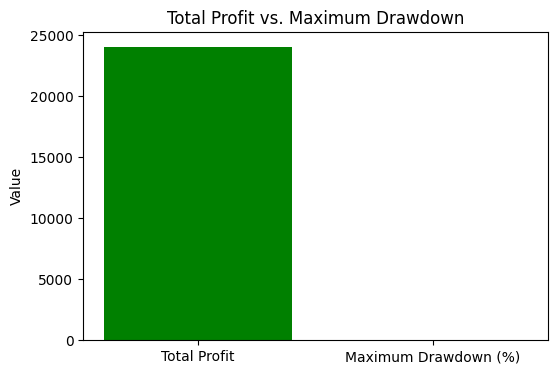

In [86]:
# Calculate total profit and total drawdown
total_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
total_drawdown = trades_df['drawdown_pct'].min() # Assuming drawdown_pct is negative for drawdowns

# Create labels and values for the bar chart
labels = ['Total Profit', 'Maximum Drawdown (%)']
values = [total_profit, abs(trades_df['drawdown_pct'].min())] # Use absolute value for drawdown percentage

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Total Profit vs. Maximum Drawdown')
plt.ylabel('Value')
plt.show()

In [87]:
# Download the trades_df as a CSV file
trades_df.to_csv('backtest_trades.csv', index=False)

print("Backtest results saved to 'backtest_trades.csv'. You can download this file from the Colab file browser.")

Backtest results saved to 'backtest_trades.csv'. You can download this file from the Colab file browser.
